# Определение стоимости автомобилей


**Цель исследования**

- построить модель, которая умеет определять рыночную стоимость автомобиля, для сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

**Описание данных:**

для проведения анализа представлен файл, содержащий данные о технических характеристиках, комплектации и ценах автомобилей:

- */datasets/autos.csv*.

**Признаки:** 

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:** Price — цена (евро).

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работы:**

1. открыть файл с данными и изучить общую информацию;
2. заполнить пропущенные значения и обработать аномалии в столбцах; удалить неинформативные признаки;
3. подготовить выборки для обучения моделей;
4. обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг; для каждой модели попробовать разные гиперпараметры;
5. проанализировать время обучения, время предсказания и качество моделей;
6. опираясь на критерии заказчика, выбрать лучшую модель и проверьте её качество на тестовой выборке;
7. написать вывод.   

## Подготовка данных

На этом этапе мы загрузим данные из представленного файла в датафрейм, изучим полученную информацию и проведем проверку на наличие пропусков и дубликатов.

In [1]:
# импортируем нужные библиотеки
!pip install category_encoders
from category_encoders.m_estimate import MEstimateEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, OrdinalEncoder)
from sklearn.model_selection import (GridSearchCV, train_test_split)
#import warnings
#warnings.filterwarnings('ignore')
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

In [2]:
# загружаем данные из файла в датафрейм и выводим основную информацию о датафрейме с помощью метода info()
data = pd.read_csv('/datasets/autos.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Как видим, в нашем датафрейме 16 столбцов и  354 369 строк. Данные в 9 столбцах (DateCrawled, VehicleType, Gearbox, Model, FuelType, Brand, Repaired, DateCreated, LastSeen) выражены строковым типом. Данные в 7 столбцах (Price, RegistrationYear, Power, Kilometer, RegistrationMonth, NumberOfPictures, PostalCode) выражены целочисленным типом. 

Сразу приведем названия столбцов к "змеиному регистру". Затем выведем на экран первые 20 строчек нашего датафрейма, посмотрим на распределение по каждому из столбцов и удалим неинформативные признаки.

In [3]:
# приводим названия столбцов к "змеиному регистру"
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [4]:
data.head(20)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Видим, что пропуски имеются по крайней мере в 5 столбцах: vehicle_type, gearbox, model, fuel_type, repaired.

Теперь удалим неинформативные признаки. Это:

- date_crawled (дата скачивания анкеты из базы);
- date_created (дата создания анкеты);
- number_of_pictures (количество фотографий автомобиля);
- postal_code (почтовый индекс владельца анкеты);
- last_seen (дата последней активности пользователя);
- registration_month (месяц регистрации автомобиля).

In [5]:
data = data.drop(['date_crawled'], axis = 1)
data = data.drop(['date_created'], axis = 1)
data = data.drop(['number_of_pictures'], axis = 1)
data = data.drop(['postal_code'], axis = 1)
data = data.drop(['last_seen'], axis = 1)
data = data.drop(['registration_month'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Таким образом, мы избавились от неинформативных признаков, привели значения столбцов к "змеиному регистру" и убедились, что выбранные типы данных корректны. Теперь проверим на наличие явных дубликатов и посмотрим количество пропусков в столбцах в процентах.

In [6]:
# проверим количество пропусков в % 
pd.DataFrame(round(data.isna().mean()*100,).sort_values(ascending=False)).style.background_gradient('coolwarm')

,0
repaired,20.000000
vehicle_type,11.000000
fuel_type,9.000000
gearbox,6.000000
model,6.000000
price,0.000000
registration_year,0.000000
power,0.000000
kilometer,0.000000
brand,0.000000


Видим, что в половине из оставшихся столбцов имеются пропуски. При этом наибольший процент пропущенных значений в столбце repaired.
Для восстановления пропущенных значений используем  класс SimpleImputer и стратегию замены пропусков наиболее часто встречающимися значениями.

In [7]:
# используем стратегию замены пропусков наиболее часто встречающимися значениями
#myImputer = SimpleImputer (strategy= 'most_frequent')
#data['repaired'] = myImputer.fit_transform(data['repaired'].values.reshape(-1,1))
#data['vehicle_type'] = myImputer.fit_transform(data['vehicle_type'].values.reshape(-1,1))
#data['fuel_type'] = myImputer.fit_transform(data['fuel_type'].values.reshape(-1,1))
#data['gearbox'] = myImputer.fit_transform(data['gearbox'].values.reshape(-1,1))
#data['model'] = myImputer.fit_transform(data['model'].values.reshape(-1,1))
#pd.DataFrame(round(data.isna().mean()*100,).sort_values(ascending=False)).style.background_gradient('coolwarm')

Начнем с изучения уникальных значений во всех столбцах с пропусками.

In [8]:
data['repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

In [9]:
data['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [10]:
data['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [11]:
data['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

In [12]:
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Видим, что в столбцах vehicle_type, fuel_type и model присутствует значение 'other'. Поэтому заменим все пропуски в данных столбцах на это значение. Полагаю, что это не приведет к существенному искажению данных. И при этом мы сохраним информацию в строках с пропусками.

In [13]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['fuel_type'] = data['fuel_type'].fillna('other')
data['model'] = data['model'].fillna('other')

In [14]:
# выведем значения из столбца repaired по частоте их встречаемости
data['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

Здесь мы видим, что доля авто, которые не были в ремонте, составляет 87% отобщего количества. Поэтому для данного столбца мы заменим пропуски на "no". Так мы и сохраним данные в строках с пропусками, и не впадем в излишне критическую ошибку) 

In [15]:
data['repaired'] = data['repaired'].fillna('no')

Доля пропусков в столбце gearbox составляет 6%. При этом при заполнении пропусков (учитывая, что одна и та же модель могла комплектоваться как механической, так и автоматической коробкой) вероятность ошибки стремится к 100%. Поэтому наиболее рациональным будет удаление строк с пропусками: доля утраченной информации не является критичной плюс мы не исказим данные.

In [16]:
# удаляем строки с пропусками в типе коробки передач
data = data.dropna(subset=['gearbox']).reset_index(drop=True)

In [17]:
# проверим количество пропусков в % 
pd.DataFrame(round(data.isna().mean()*100,).sort_values(ascending=False)).style.background_gradient('coolwarm')

,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


Пропуски обработаны. Теперь перейдем к поиску дубликатов.

In [18]:
# проверим на наличие явных дубликатов
data.duplicated().sum()

49443

In [19]:
data = data.drop_duplicates() 
data.duplicated().sum()

0

Видим, что явных дубликатов в датафрейме больше нет. Поиск неявных дубликатов приминительно к данному случаю полагаю нецелесообразным. Поэтому теперь посмотрим на распределение по каждому из столбцов.

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,285093.0,4654.479777,4616.454714,0.0,1200.0,2950.0,6800.0,20000.0
registration_year,285093.0,2003.482772,32.540388,1000.0,1999.0,2003.0,2008.0,9000.0
power,285093.0,115.492976,204.039422,0.0,75.0,106.0,144.0,20000.0
kilometer,285093.0,127472.859733,37778.798259,5000.0,125000.0,150000.0,150000.0,150000.0


Обнаружили следующие аномалии:

- имеются авто с ценой 0 евро;
- имеются авто, зарегистрированные в 1000 году и зарегистрированные в 9000 году;
- имеются авто с мощностью двигателя 0 л.с. и с мощностью 20 000 л.с.

Диапазон значений пробега авто от 5 000 км до 150 000 км представляется вполне разумным.

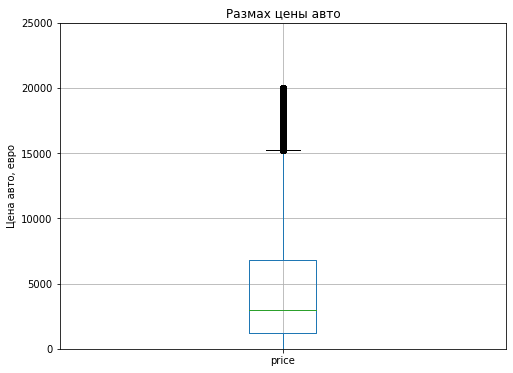

In [21]:
# посторим диаграмму размаха для цены
data.boxplot(column='price', figsize=(8, 6))
plt.title('Размах цены авто')
plt.ylim(0, 25000)
plt.ylabel('Цена авто, евро')
plt.show()

In [22]:
# оставим в столбце авто с ценой от 1 250 евро и выше
data = data.query('1250 <= price')

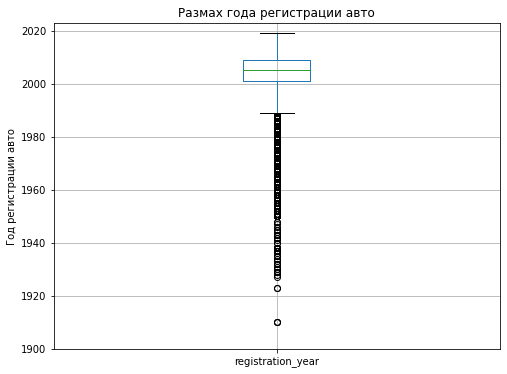

In [23]:
# посторим диаграмму размаха для года регистрации авто
# для посторения диаграммы возьмем диапазон от 1900 настоящего времени (т.е. до 2023 года)
data.boxplot(column='registration_year', figsize=(8, 6))
plt.title('Размах года регистрации авто')
plt.ylim(1900, 2023)
plt.ylabel('Год регистрации авто')
plt.show()

In [24]:
# оставим в столбце авто с годом регистрации с 1985 по 2016 включительно
data = data.query('1985 <= registration_year <= 2016')

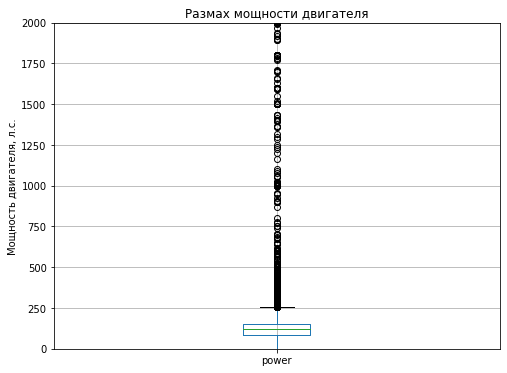

In [25]:
# посторим диаграмму размаха для мощности двигателя
data.boxplot(column='power', figsize=(8, 6))
plt.title('Размах мощности двигателя')
plt.ylim(0, 2000)
plt.ylabel('Мощность двигателя, л.с.')
plt.show()

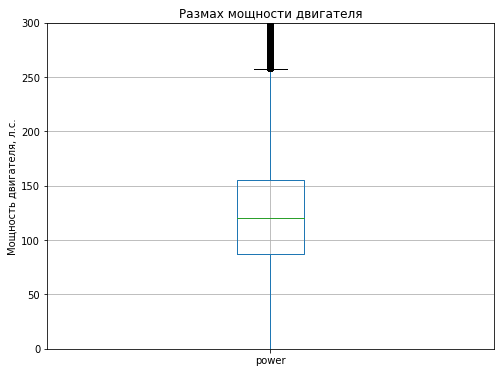

In [26]:
# видим, что максимальная мощность двигателя для авто в нашем датафрейме составляет примерно 250 л.с. 
# поэтому ограничим диапазон диаграммы значениями от 0 до 300
data.boxplot(column='power', figsize=(8, 6))
plt.title('Размах мощности двигателя')
plt.ylim(0, 300)
plt.ylabel('Мощность двигателя, л.с.')
plt.show()

In [27]:
# полагаю разумным оставить авто с мощностью двигателя от 50 до 255 л.с.
data = data.query('50 <= power <= 255')

In [28]:
# посмотрим на получившиеся распределения значений по столбцам
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,182095.0,6074.870974,4515.453814,1250.0,2500.0,4500.0,8490.0,20000.0
registration_year,182095.0,2004.631033,5.314753,1985.0,2001.0,2005.0,2008.0,2016.0
power,182095.0,126.709404,44.674215,50.0,94.0,120.0,150.0,255.0
kilometer,182095.0,123633.460556,38879.011544,5000.0,100000.0,150000.0,150000.0,150000.0


Теперь значения столбцов выглядят вполне разумно. Выведем на экран первые 20 строчек нашего датафрейма

In [29]:
data = data.reset_index(drop=True)
data.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
5,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
6,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
7,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
8,2500,wagon,2004,manual,131,passat,150000,other,volkswagen,no
9,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no


In [30]:
# сбросим индексы и выведем снова первые 20 строчек
#data = data.reset_index(drop=True)
#data.head(20)

In [31]:
# выведем значения из столбца model по частоте их встречаемости
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#data['model'].value_counts()

Для минимизации количества столбцов, которые появятся после кодирования, полагаю разумным ограничиться наиболее часто встречающимися в столбце model категориями: оставим значения, встречающиеся от 1 000 и более раз. Таких значений у нас 36.

In [32]:
# оставим в датафрейме 35 наиболее часто встречающихся значений в столбце model 
#data = data.query('model in ["golf", "other", "3er", "a4", "passat", "astra", "polo", "c_klasse", "5er", \
#"e_klasse", "corsa", "a3", "a6", "focus", "transporter", "2_reihe", "fortwo", "fiesta", "a_klasse", "1er", "touran", \
#"zafira", "3_reihe", "ibiza", "fabia", "mondeo", "clio", "octavia", "vectra", "megane", "cooper", "clk", "twingo", \
#"caddy", "x_reihe", "i_reihe"]')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182095 entries, 0 to 182094
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              182095 non-null  int64 
 1   vehicle_type       182095 non-null  object
 2   registration_year  182095 non-null  int64 
 3   gearbox            182095 non-null  object
 4   power              182095 non-null  int64 
 5   model              182095 non-null  object
 6   kilometer          182095 non-null  int64 
 7   fuel_type          182095 non-null  object
 8   brand              182095 non-null  object
 9   repaired           182095 non-null  object
dtypes: int64(4), object(6)
memory usage: 13.9+ MB


In [34]:
data.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
5,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
6,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
7,2799,wagon,2005,manual,140,passat,150000,gasoline,volkswagen,yes
8,2500,wagon,2004,manual,131,passat,150000,other,volkswagen,no
9,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no


На данном этапе мы сделали следующее:

- изучили данные, выяснили, что в датафрейме 16 столбцов и 354 369 строк. Данные в 9 столбцах (DateCrawled, VehicleType, Gearbox, Model, FuelType, Brand, Repaired, DateCreated, LastSeen) выражены строковым типом. Данные в 7 столбцах (Price, RegistrationYear, Power, Kilometer, RegistrationMonth, NumberOfPictures, PostalCode) выражены целочисленным типом.
- Привели названия столбцов к "змеиному регистру".
- Удалили неинформативные признаки: date_crawled (дата скачивания анкеты из базы), date_created (дата создания анкеты), number_of_pictures (количество фотографий автомобиля), postal_code (почтовый индекс владельца анкеты), last_seen (дата последней активности пользователя) и registration_month (месяц регистрации автомобиля).
- Обработали пропуски, применив стратегию замены пропусков наиболее часто встречающимися значениями.
- Удалили явные дубликаты.
- Обработали аномалии в столбцах price, registration_year и power.
- Для минимизации количества столбцов, которые появятся после кодирования, оставили в датафрейме 36 наиболее часто встречающихся значений в столбце model.

Теперь данные готовы для обучения моделей и мы можем перейти к следующему шагу.

## Обучение моделей

In [35]:
# проведем кодирование категориальных призаков при помощи OneHotEncoder
#encoder = OneHotEncoder(handle_unknown='ignore')
#encoder_ohe = pd.DataFrame(encoder.fit_transform(data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand',\
                                                       #'repaired']]).toarray(), index=data.index)
#data_ohe = data.join(encoder_ohe)
#data_ohe.head(15)

In [36]:
#удаляем исходные столбцы (некодированные категориальные), т.к. они нам больше не нужны
#data_ohe.drop(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], axis= 1 , inplace= True )
#data_ohe.head(15)

In [37]:
# извлекаем признаки
features = data.drop(['price'], axis=1)
target = data['price']

In [38]:
# разделяем на выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(136571, 9)

(45524, 9)

(136571,)

(45524,)

In [39]:
X_train.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
148488,small,2006,manual,109,forfour,150000,petrol,smart,no
116772,wagon,2006,manual,163,3er,150000,gasoline,bmw,no
176184,coupe,1993,auto,150,e_klasse,150000,petrol,mercedes_benz,no
124379,wagon,2006,manual,105,a3,150000,gasoline,audi,no
59309,sedan,2004,manual,140,golf,100000,gasoline,volkswagen,no


In [40]:
# используем MEstimateEncoder для кодирования столбцов brand и model
enc = ['brand', 'model']
me = MEstimateEncoder(cols=enc, m=5.0)
me.fit(X_train[enc], y_train)
X_train[enc]=me.transform(X_train[enc])
X_test[enc]=me.transform(X_test[enc])
X_train.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
148488,small,2006,manual,109,3134.982734,150000,petrol,4484.046265,no
116772,wagon,2006,manual,163,6228.876998,150000,gasoline,7294.823868,no
176184,coupe,1993,auto,150,6515.518195,150000,petrol,6645.987889,no
124379,wagon,2006,manual,105,7399.533433,150000,gasoline,7652.137282,no
59309,sedan,2004,manual,140,6146.917474,100000,gasoline,6286.305640,no


In [41]:
# кодируем оставшиеся категориальные значения с помощью get_dummies
X_train = pd.get_dummies(X_train, columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired'], drop_first=True)
X_test = pd.get_dummies(X_test, columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired'], drop_first=True)
X_train.head()

,registration_year,power,model,kilometer,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_yes
148488,2006,109,3134.982734,150000,4484.046265,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
116772,2006,163,6228.876998,150000,7294.823868,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
176184,1993,150,6515.518195,150000,6645.987889,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
124379,2006,105,7399.533433,150000,7652.137282,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0
59309,2004,140,6146.917474,100000,6286.305640,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0


In [42]:
# масштабируем
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Признаки подготовлены. Теперь можно перейти к обучению моделей. Вначале обучим модель без бустинга (по условиям проекта достаточно одной такой модели). Выберем Случайный лес. Затем перейдем к LightGBM и CatBoost.**

**Рассмотрим случайный лес**

In [43]:
%%time
forest = GridSearchCV(estimator=RandomForestRegressor(random_state=12345), param_grid={ 
    'n_estimators': range(10, 110, 10),
    'max_depth': range(2, 15, 1)}, cv=3)
forest.fit(X_train, y_train)

print('Оптимальные значения параметров:', forest.best_params_)

Оптимальные значения параметров: {'max_depth': 15, 'n_estimators': 110}
CPU times: user 2min 29s, sys: 636 ms, total: 2min 30s
Wall time: 2min 30s


In [44]:
%%time
pred_2 = forest.predict(X_test)
print('RMSE:', mean_squared_error(y_test, pred_2, squared=False))

RMSE: 1654.6300492944333
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.13 s


**Рассмотрим LightGBM**

In [46]:
%%time
gbm = GridSearchCV(estimator=LGBMRegressor(random_state=12345), param_grid={ 
    'n_estimators': range(90, 110, 10),
    'num_leaves': range(20, 40, 10)}, cv=2)
gbm.fit(X_train, y_train)
print('Оптимальные значения параметров:', gbm.best_params_)

Оптимальные значения параметров: {'n_estimators': 110, 'num_leaves': 31}
CPU times: user 21min 1s, sys: 8.29 s, total: 21min 10s
Wall time: 21min 18s


In [47]:
%%time
pred_3 = gbm.predict(X_test)
print('RMSE:', mean_squared_error(y_test, pred_3, squared=False))

RMSE: 1669.3503097300068
CPU times: user 412 ms, sys: 3.41 ms, total: 415 ms
Wall time: 344 ms


**Рассмотрим CatBoost**

In [48]:
%%time
cbr = CatBoostRegressor(loss_function='RMSE', silent=True, random_state=12345)
cbr_param = {'iterations': range(20, 60, 20),'depth': range(5, 10, 2)}

cbr_g = GridSearchCV(cbr, cbr_param, cv=3)
cbr_g.fit(X_train, y_train);

print('Оптимальные значения параметров:', cbr_g.best_params_)

Оптимальные значения параметров: {'depth': 10, 'iterations': 60}
CPU times: user 36.7 s, sys: 249 ms, total: 36.9 s
Wall time: 1min


In [49]:
%%time
pred_4 = cbr_g.predict(X_test)
print('RMSE:', mean_squared_error(y_test, pred_4, squared=False))

RMSE: 1627.0598098482212
CPU times: user 19.6 ms, sys: 3 µs, total: 19.6 ms
Wall time: 22.2 ms


На данном этапе мы провели кодирование категориальных признаков, разделение на выборки и масштабирование. После чего обучили 4 выбранных модели (с подбором оптимальных гиперпараметров).

Обучение наших моделей завершено. Анализ полученных результатов и выбор лучшей модели мы проведем на следующем этапе проекта.

## Анализ моделей

По условиям проекта значение метрики RMSE должно быть меньше 2500. Этому условию соответствуют все испытанные в проекте модели. Но, кроме того, заказчику важны следующие параметры: качество предсказания, скорость предсказания, время обучения. 
Для определения лучшей модели сведем полученные о наших моделях данные в таблицу.

In [50]:
tab = [[150, 1130, 1654.63],
        [1278, 344, 1669.35],
        [60, 22.2, 1627.06]]

model = ["RandomForestRegressor", "LGBMRegressor", "CatBoostRegressor"]
pd.DataFrame(data=tab, index=model, columns=["Время обучения, с", "Скорость предсказания, мс", "RMSE"])

,"Время обучения, с","Скорость предсказания, мс",RMSE
RandomForestRegressor,150,1130.0,1654.63
LGBMRegressor,1278,344.0,1669.35
CatBoostRegressor,60,22.2,1627.06


Из таблицы мы видим, что все испытанные модели укладываются в критерий "RMSE меньше 2 500". При этом CatBoostRegressor показал немного лучшее значение этой метрики при существенно меньших затратах времени на обучение и предсказание. Исходя из этих данных делаем выбор в пользу CatBoostRegressor.

## Общий вывод:

Целью нашего проекта было построить модель, которая умеет определять рыночную стоимость автомобиля, для сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

Для проведения анализа был представлен следующий файл:

- */datasets/autos.csv*.

**Признаки:** 

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:** Price — цена (евро).

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

На этапе изучения и предобработки даннных мы выяснили следующее:

- изучили данные, выяснили, что в датафрейме 16 столбцов и 354 369 строк. Данные в 9 столбцах (DateCrawled, VehicleType, Gearbox, Model, FuelType, Brand, Repaired, DateCreated, LastSeen) выражены строковым типом. Данные в 7 столбцах (Price, RegistrationYear, Power, Kilometer, RegistrationMonth, NumberOfPictures, PostalCode) выражены целочисленным типом.
- Привели названия столбцов к "змеиному регистру".
- Удалили неинформативные признаки: date_crawled (дата скачивания анкеты из базы), date_created (дата создания анкеты), number_of_pictures (количество фотографий автомобиля), postal_code (почтовый индекс владельца анкеты), last_seen (дата последней активности пользователя) и registration_month (месяц регистрации автомобиля).
- Обработали пропуски, применив стратегию замены пропусков наиболее часто встречающимися значениями.
- Удалили явные дубликаты.
- Обработали аномалии в столбцах price, registration_year и power.


По условиям проекта значение метрики RMSE должно быть меньше 2500. Этому условию соответствуют все испытанные в проекте модели. Но, кроме того, заказчику важны следующие параметры: качество предсказания, скорость предсказания, время обучения. Для определения лучшей модели мы свели полученные о наших моделях данные в таблицу.

Из таблицы мы видим, что все испытанные модели укладываются в критерий "RMSE меньше 2 500". При этом CatBoostRegressor показал немного лучшее значение этой метрики при существенно меньших затратах времени на обучение и предсказание. Исходя из этих данных делаем выбор в пользу CatBoostRegressor.

Таким образом, цель проекта достигнута - получена модель, удовлетворяющая требованиям заказчика.


 
